Aluno: Lucas Garavaglia

In [8]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
from river import drift
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Loading stream

In [46]:
train_set_yoga = pd.read_csv('./dataStream/Datasets/benchmark_real/Yoga_TRAIN.data')
test_set_yoga = pd.read_csv('./dataStream/Datasets/benchmark_real/Yoga_TEST.data')

train_set_uwave = pd.read_csv('./dataStream/Datasets/benchmark_real/UWave_TRAIN.data')
test_set_uwave = pd.read_csv('./dataStream/Datasets/benchmark_real/UWave_TEST.data')

train_set_waveform = pd.read_csv('./dataStream/Datasets/benchmark_synthetic/Waveform-Abrupt_TRAIN.data')
test_set_waveform = pd.read_csv('./dataStream/Datasets/benchmark_synthetic/Waveform-Abrupt_TEST.data')

## Baseline

In [2]:
def baseline_classifier(train_set, test_set):
    
    train_X = train_set.iloc[:,:-1]
    test_X = test_set.iloc[:,:-1]
    train_y = train_set.iloc[:,-1]
    test_y = test_set.iloc[:,-1]
    
    vet_acc = np.zeros(len(test_y))
    
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(train_X, train_y)
    
    for i in range(0,len(test_y)):
        prediction = clf.predict(test_X.iloc[[i]])
        if prediction == test_y[i]:
            vet_acc[i] = 1    
    
    mean_acc = np.mean(vet_acc)*100
    
    return (mean_acc, vet_acc)   
    

In [3]:
def topline_classifier(train_set, test_set):
    
    ## 
    train_X = train_set.iloc[:,:-1]
    test_X = test_set.iloc[:,:-1]
    train_y = train_set.iloc[:,-1]
    test_y = test_set.iloc[:,-1]

    vet_acc = np.zeros(len(test_y))
    
    window_length = 500
    
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(train_X, train_y)
    
    for i in range(0, window_length):
        prediction = clf.predict(test_X.iloc[[i]]) 
        if prediction == test_y[i]:
            vet_acc[i] = 1


    for i in range(window_length, len(test_y)):
        
        clf.fit(test_X.iloc[i-window_length:i], test_y.iloc[i-window_length:i])
        prediction = clf.predict(test_X.iloc[[i]]) 
        if prediction == test_y[i]:
            vet_acc[i] = 1
    
    mean_acc = np.mean(vet_acc)*100
    
    return mean_acc, vet_acc

In [4]:
def adwin_classifier(train_set, test_set):
    adwin = drift.ADWIN()
    ## 
    train_X = train_set.iloc[:,:-1]
    test_X = test_set.iloc[:,:-1]
    train_y = train_set.iloc[:,-1]
    test_y = test_set.iloc[:,-1]

    vet_acc = np.zeros(len(test_y))
    
    window_length = 500
    
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(train_X, train_y)
    
    for i in range(0, window_length):
        prediction = clf.predict(test_X.iloc[[i]]) 
        if prediction == test_y[i]:
            vet_acc[i] = 1

    for i in range(window_length, len(test_y)):
        prediction = clf.predict(test_X.iloc[[i]]) 
        _ = adwin.update(prediction)
        if adwin.change_detected:
            clf.fit(test_X.iloc[i-window_length:i], test_y.iloc[i-window_length:i])
        if prediction == test_y[i]:
            vet_acc[i] = 1
    
    mean_acc = np.mean(vet_acc)*100
    
    return mean_acc, vet_acc

In [5]:
def lat0_classifier(train_set, test_set):
    train_X = train_set.iloc[:,:-1]
    test_X = test_set.iloc[:,:-1]
    train_y = train_set.iloc[:,-1]
    test_y = test_set.iloc[:,-1]

    vet_acc = np.zeros(len(test_y))
    
    window_length = 500
    
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(train_X, train_y)
    
    for i in range(0, window_length):
        prediction = clf.predict(test_X.iloc[[i]]) 
        if prediction == test_y[i]:
            vet_acc[i] = 1

    for i in range(window_length, len(test_y)):
        prediction = clf.predict(test_X.iloc[[i]]) 
        if prediction == test_y[i]:
            vet_acc[i] = 1
        if np.mean(vet_acc[i-window_length:i]) < 0.8:
            clf.fit(test_X.iloc[i-window_length:i], test_y.iloc[i-window_length:i])
    
    mean_acc = np.mean(vet_acc)*100
    
    return mean_acc, vet_acc

In [48]:
[mean_acc_lat0_yoga, acc_vetor_lat0_yoga] = lat0_classifier(train_set_yoga, test_set_yoga)
[mean_acc_base_line_yoga, acc_vetor_base_line_yoga] = baseline_classifier(train_set_yoga, test_set_yoga)
[mean_acc_adwin_yoga, acc_vetor_adwin_yoga] = adwin_classifier(train_set_yoga, test_set_yoga)

In [49]:
[mean_acc_lat0_uwave, acc_vetor_lat0_uwave] = lat0_classifier(train_set_uwave, test_set_uwave)
[mean_acc_base_line_uwave, acc_vetor_base_line_uwave] = baseline_classifier(train_set_uwave, test_set_uwave)
[mean_acc_adwin_uwave, acc_vetor_adwin_uwave] = adwin_classifier(train_set_uwave, test_set_uwave)

In [50]:
[mean_acc_lat0_waveform, acc_vetor_lat0_waveform] = lat0_classifier(train_set_waveform, test_set_waveform)
[mean_acc_base_line_waveform, acc_vetor_base_line_waveform] = baseline_classifier(train_set_waveform, test_set_waveform)
[mean_acc_adwin_waveform, acc_vetor_adwin_waveform] = adwin_classifier(train_set_waveform, test_set_waveform)

# Results

In [13]:
def plot_results(vet_acc, window, method_name):
    vet_len = len(vet_acc)
    mean_acc = []
    for i in range(0, vet_len, window):
        mean_acc.append(np.mean(vet_acc[i:i+window]))
    
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.plot([float(x)*window for x in range(0,len(mean_acc))], mean_acc, marker='.', label=method_name )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Examples')
    plt.ylabel('Accuracy') 
    plt.legend()

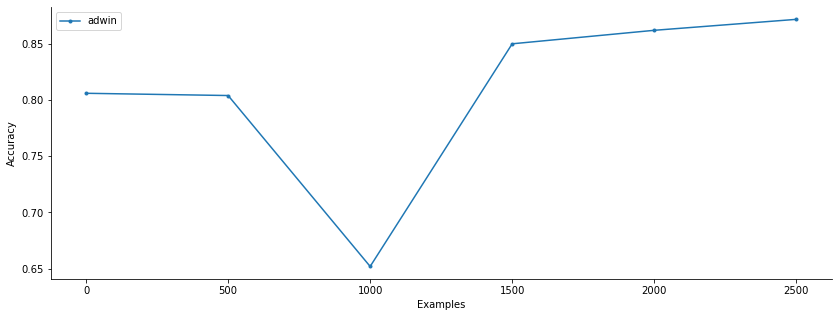

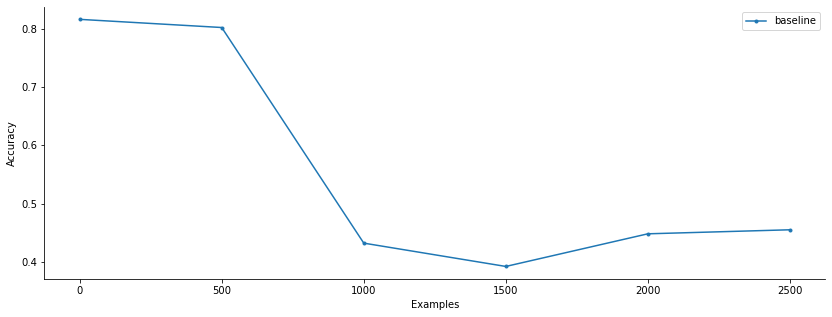

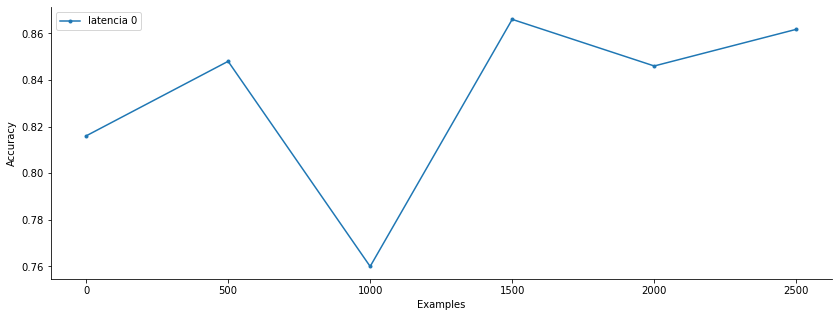

In [52]:
plot_results(acc_vetor_adwin_yoga, 500, 'adwin')
plot_results(acc_vetor_base_line_yoga, 500, 'baseline')
plot_results(acc_vetor_lat0_yoga, 500, 'latencia 0')

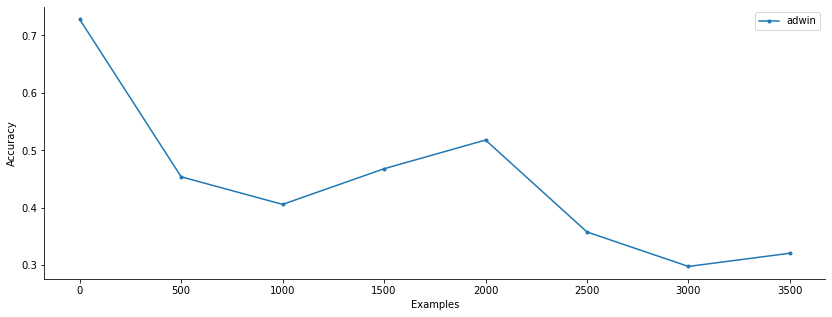

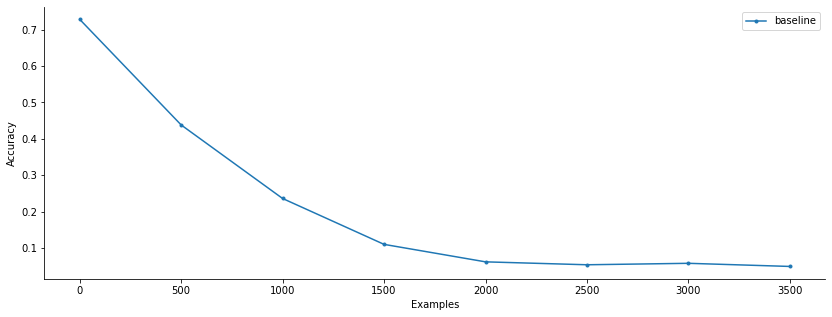

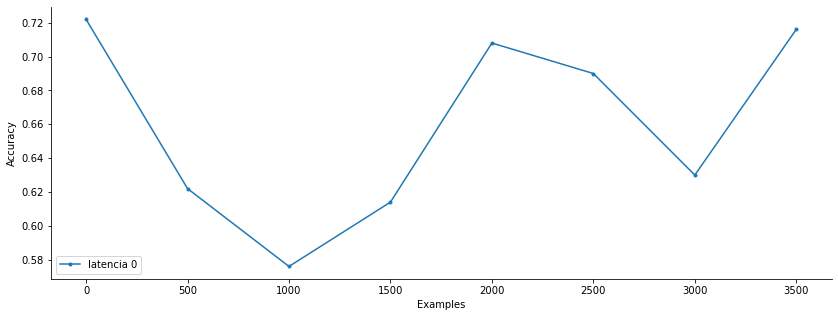

In [53]:
plot_results(acc_vetor_adwin_uwave, 500, 'adwin')
plot_results(acc_vetor_base_line_uwave, 500, 'baseline')
plot_results(acc_vetor_lat0_uwave, 500, 'latencia 0')

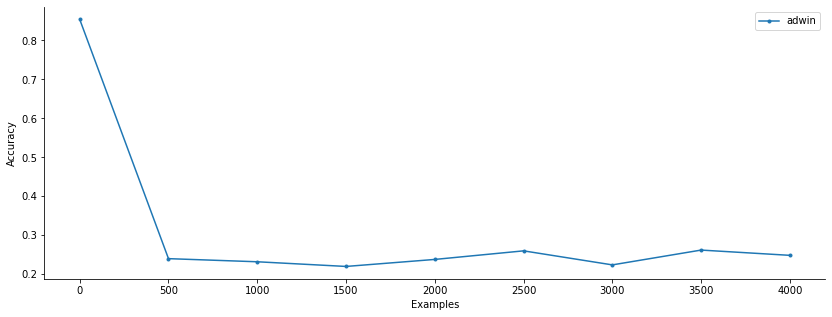

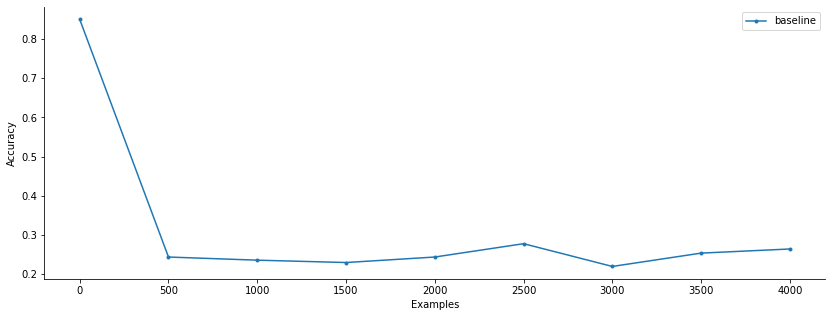

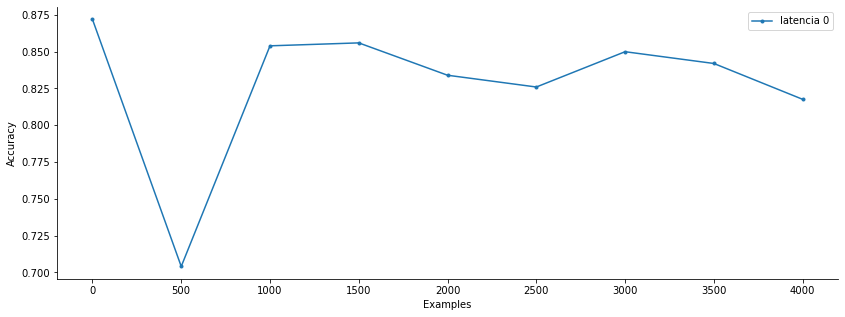

In [54]:
plot_results(acc_vetor_adwin_waveform, 500, 'adwin')
plot_results(acc_vetor_base_line_waveform, 500, 'baseline')
plot_results(acc_vetor_lat0_waveform, 500, 'latencia 0')

In [58]:
friedmanchisquare(acc_vetor_adwin_yoga, acc_vetor_base_line_yoga, acc_vetor_lat0_yoga)

FriedmanchisquareResult(statistic=953.8916857360667, pvalue=7.329127480154782e-208)

In [66]:
sp.posthoc_nemenyi_friedman(np.array([acc_vetor_adwin_yoga, acc_vetor_base_line_yoga, acc_vetor_lat0_yoga]).T)

,0,1,2
0,1.000000,0.001,0.304992
1,0.001000,1.000,0.001000
2,0.304992,0.001,1.000000


Dada a hipótese h0 sendo os algoritmos iguais e h1 sendo os algoritmos diferentes e dados o alpha = 0.05 temos que a hipótese h0 foi rejeitada

In [65]:
sp.posthoc_nemenyi_friedman(np.array([acc_vetor_adwin_uwave, acc_vetor_base_line_uwave, acc_vetor_lat0_uwave]).T)

,0,1,2
0,1.000,0.001,0.001
1,0.001,1.000,0.001
2,0.001,0.001,1.000


Dada a hipótese h0 sendo os algoritmos iguais e h1 sendo os algoritmos diferentes e dados o alpha = 0.05 temos que a hipótese h0 foi rejeitada

In [64]:
sp.posthoc_nemenyi_friedman(np.array([acc_vetor_adwin_waveform, acc_vetor_base_line_waveform, acc_vetor_lat0_waveform]).T)

,0,1,2
0,1.000,0.900,0.001
1,0.900,1.000,0.001
2,0.001,0.001,1.000


Dada a hipótese h0 sendo os algoritmos iguais e h1 sendo os algoritmos diferentes e dados o alpha = 0.05 temos que a hipótese h0 foi rejeitada

# Trabalho 2

Considere o problema de fluxo de dados estudado nas últimas aulas, bem como o este notebook, incluindo o **baseline** e o **topline** para implementar opções alternativas a essas duas abordagens para os seguinte cenários:

+ Latência nula, isto é, tão logo a classificação é realizada o rótulo verdadeiro é disponibilizado. Portanto, neste cenário é possível utilizar métodos supervisionados para realizar a detecção de mudança de conceito;

+ Latência extrema, neste caso, os rótulos das instâncias não são disponibilizados. Portanto, a identificação da mudança de conceito deverá ser realizada sem a presença de rótulos. Somente após a detecção os rótulos das instâncias poderão ser solicitados, considerando uma janela W. Ou seja, poderá incluir todas as instâncias do fluxo a partir de t -|W|:|t|. **Você também poderá usar alguma outra configuração de janela**.

Por fim, a entrega deverá envolver datasets disponíveis no Teams que permita a adequada comparação entre as soluções e o **baseline** e o **topline** para cada cenário. 